In [1]:
# !pip3 install numpy pymoo wntr

In [2]:
import numpy as np

from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.factory import get_algorithm, get_crossover, get_mutation, get_sampling
import time
import wntr
from wntr.network.model import LinkStatus

In [3]:
PIPE_DIA = [12, 16, 20, 24, 30, 40]
H_MIN = 30

In [4]:
wn_global = wntr.network.WaterNetworkModel('./Hanoi.inp')
results = wntr.sim.EpanetSimulator(wn_global).run_sim()

In [47]:
class P(Problem):
    def __init__(self):
        super().__init__(
            n_var=34,
            n_obj=1,
            n_constr=0,
            xl=np.array([0]*34),
            xu=np.array([5]*34),
            type_var=np.int,
            elementwise_evaluation=True
            )

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 0

        wn, results = update_net(x)
        for i in range(0, 34):
            f1 += 1.1*(PIPE_DIA[x[i]]**1.5)*(wn.get_link(i+1).length)
        for i in range(1, 33):
            f1 += 1000000000*abs(min(0, results.node['head']['{}'.format(i)][0]-H_MIN))

        out["F"] = np.column_stack([f1])

In [48]:
def update_net(el, wn=wn_global):
    newres, newnet = None, None
    for i in range(1, 35):
        # print(i, el[i-1])
        wn.get_link(i).diameter = PIPE_DIA[el[i-1]] * 0.0254
    wn.write_inpfile("abc.inp")
    
    wn = wntr.network.WaterNetworkModel("abc.inp")
    newnet = wn
    newres = wntr.sim.EpanetSimulator(wn).run_sim()
    return newnet, newres

with open("hanoi.inp", "r") as f:
    lines = f.readlines()
    print(lines[48 + 1])

In [49]:
algorithm = get_algorithm(
    "ga",
    pop_size=100,
    sampling=get_sampling("int_random"),
    crossover=get_crossover("int_sbx", prob=1.0, eta=3.0),
    mutation=get_mutation("int_pm", eta=3.0),
    eliminate_duplicates=True,
    )

In [50]:
problem = P()

/Users/saihridikpunukollu/Desktop/Acads/3-2/Engineering Hydrology/Project/env/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [51]:
beg = time.time()
res = minimize(problem, algorithm, seed=1, verbose=True, save_history=True)
print(res.X, res.F)
print([PIPE_DIA[i] for i in res.X])
end = time.time()
print(end - beg)

n_gen |  n_eval |     fopt     |     favg    
    1 |     100 |  3.05356E+12 |  8.81718E+13
    2 |     200 |  3.05356E+12 |  1.65116E+13
    3 |     300 |  2.59321E+12 |  8.55350E+12
    4 |     400 |  5.14203E+11 |  5.37531E+12
    5 |     500 |  5.14203E+11 |  3.41611E+12
    6 |     600 |  3.09230E+11 |  2.17368E+12
    7 |     700 |  3.09230E+11 |  1.36772E+12
    8 |     800 |  1.56197E+11 |  7.94773E+11
    9 |     900 |  1.52905E+11 |  4.95920E+11
   10 |    1000 |  7.36032E+10 |  3.51264E+11
   11 |    1100 |  3.91478E+10 |  2.42346E+11
   12 |    1200 |  3.91478E+10 |  1.64787E+11
   13 |    1300 |  2.05491E+10 |  9.77108E+10
   14 |    1400 |  8.05751E+06 |  5.21356E+10
   15 |    1500 |  7.92135E+06 |  2.54227E+10
   16 |    1600 |  7.45873E+06 |  1.25395E+10
   17 |    1700 |  7.45873E+06 |  5.01757E+09
   18 |    1800 |  7.40875E+06 |  1.75193E+08
   19 |    1900 |  7.40212E+06 |  7.90716E+06
   20 |    2000 |  7.40212E+06 |  7.73398E+06
   21 |    2100 |  7.28814E+06 |  

In [58]:
print([PIPE_DIA[res.X[i]] for i in range(len(res.X))])

,0
0,40
1,40
2,40
3,40
4,40
5,40
6,40
7,40
8,30
9,30


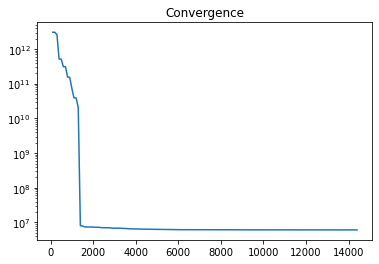

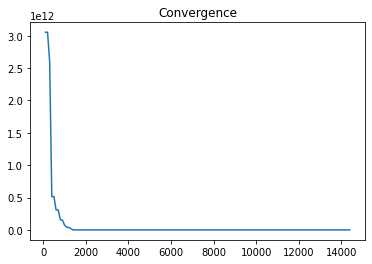

In [52]:
import matplotlib.pyplot as plt
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, opt)
plt.yscale("log")
plt.show()

plt.title("Convergence")
plt.plot(n_evals, opt)
plt.show()

In [27]:
import pandas as pd

In [59]:
df = pd.DataFrame([40, 40, 40, 40, 40, 40, 40, 40, 30, 30, 30, 24, 20, 12, 12, 12, 20, 24, 20, 40, 20, 12, 40, 30, 30, 20, 12, 12, 16, 12, 12, 20, 16, 24], columns=["Diameter"])

In [60]:
df.index.rename("Pipe #", inplace=True)
df.index += 1

In [62]:
df[17:]

,Diameter
Pipe #,
18,24
19,20
20,40
21,20
22,12
23,40
24,30
25,30
26,20
